In [33]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D 


plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 18})

In [48]:
L = 10 # define domain
x2 = np.arange(-L,L,0.1) 
n = len(x2)
k = n*(2*np.pi/(2*L))*np.fft.fftfreq(n) # k-vector
ye = np.exp(-np.power(x2,2))
ye2 = np.exp(np.power(x2,2)/2) # define Gaussians

y = np.zeros((n,10))

for jj in range(10): # loop through 10 modes
    # 2nd derivative
    yd = np.real(np.fft.ifft((np.power((1j)*k,jj))*np.fft.fft(ye)))
    
    mode = np.power(-1,jj) * \
        np.power((np.power(2,jj)*np.math.factorial(jj)*np.sqrt(np.pi)),-0.5) * \
        ye2 * yd
            
    y[:,jj] = mode # store modes as columns
            
x = x2[int(n/2)-40 : int(n/2)+41] # keep only -4<x<4
yharm = y[int(n/2)-40 : int(n/2)+41,:]
n = len(x)
f = np.exp(-np.power(x-0.5,2)) + 3*np.exp(-2*np.power(x+1.5,2))

E = np.zeros(13)
con = np.zeros(13)

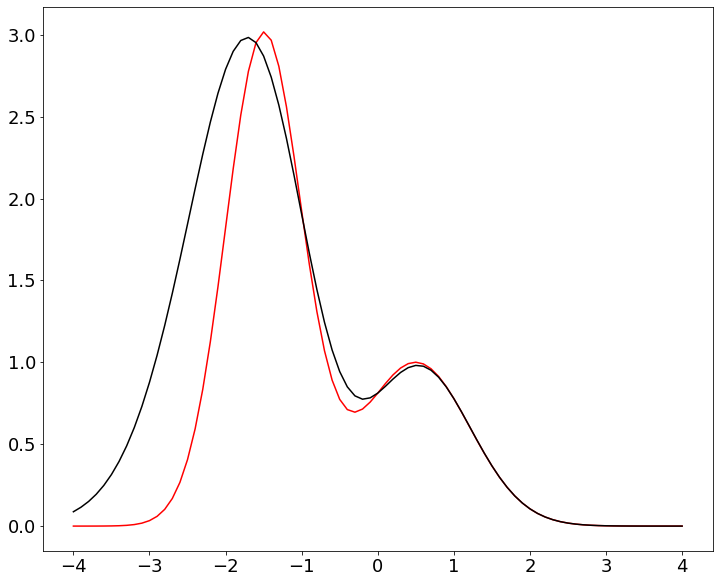

In [49]:
## Method 1 -- Start with max of each mode
ns = np.array([],dtype='int')

for jj in range(10): # walk through the modes
    n1 = np.argmax(yharm[:,jj]) # pick max
    s1 = yharm[n1,jj]
    ns = np.append(ns,n1)

P = np.zeros(n)
P[ns] = 1

# compute M matrix
M2 = np.zeros((10,10))
for jj in range(10):
    for kk in range(jj+1):
        Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
        M2[jj,kk] = Area
        M2[kk,jj] = Area

ftild = np.zeros(10)
for jj in range(10): # reconstruction using gappy
    ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
atild = np.linalg.solve(M2,ftild) # compute error
f1 = yharm @ atild        # iterative reconstruction
E[0] = np.linalg.norm(f1-f) # iterative error
con[0] = np.linalg.cond(M2)

plt.plot(x,f,'r')
plt.plot(x,f1,'k')
plt.show()

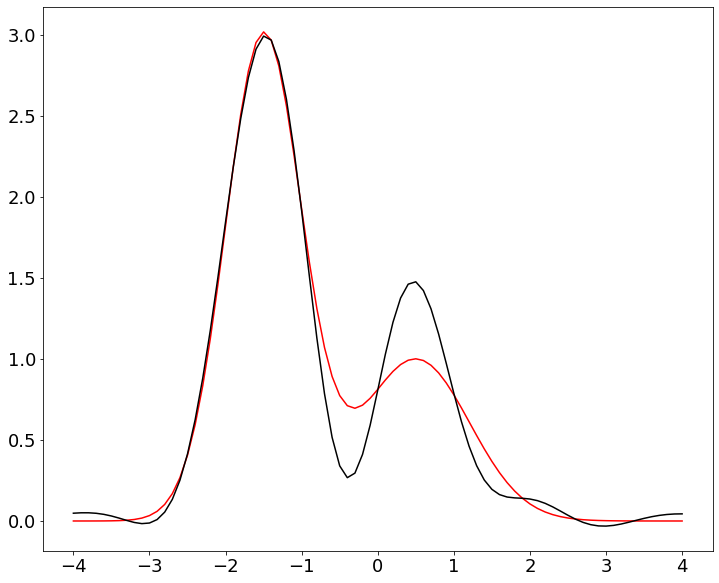

In [50]:
## Method 2 -- Start with max and mins of each mode
ns = np.array([],dtype='int')

for jj in range(10): # walk through the modes
    n1 = np.argmax(yharm[:,jj]) # pick max
    s1 = yharm[n1,jj]
    ns = np.append(ns,n1)

for jj in range(1,10): # no minimum on first mode
    n2 = np.argmin(yharm[:,jj]) # pick min
    s2 = yharm[n2,jj]
    ns = np.append(ns,n2)
    
    
P = np.zeros(n)
P[ns] = 1

# compute M matrix
M2 = np.zeros((10,10))
for jj in range(10):
    for kk in range(jj+1):
        Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
        M2[jj,kk] = Area
        M2[kk,jj] = Area

ftild = np.zeros(10)
for jj in range(10): # reconstruction using gappy
    ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
atild = np.linalg.solve(M2,ftild) # compute error
f1 = yharm @ atild        # iterative reconstruction
E[1] = np.linalg.norm(f1-f) # iterative error
con[1] = np.linalg.cond(M2)

plt.plot(x,f,'r')
plt.plot(x,f1,'k')
plt.show()

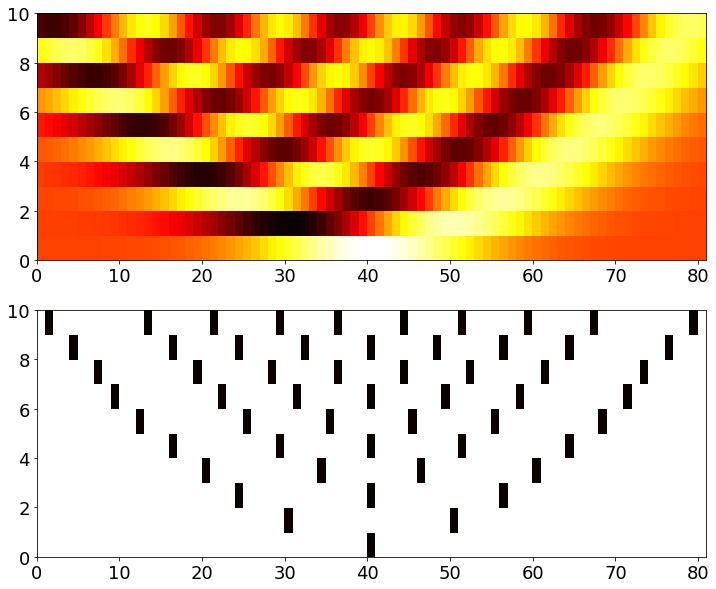

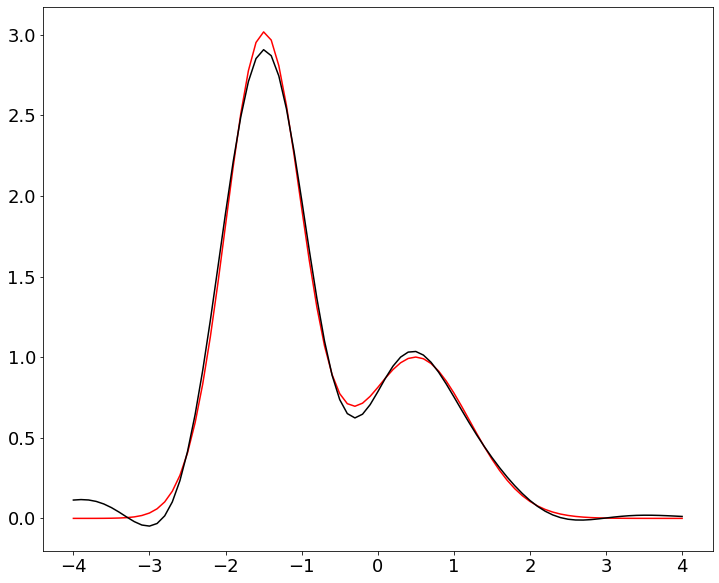

In [51]:
## Method 3 -- Search for extrema, then select random N sensors
nmax = np.array([],dtype='int')
nmin = np.copy(nmax)
Psum = np.zeros((n,10))
for jj in range(10): # walk through the modes
    nmaxt = np.array([],dtype='int')
    nmint = np.copy(nmaxt)
    
    for kk in range(1,n-1):
        if yharm[kk,jj] > yharm[kk-1,jj] and yharm[kk,jj] > yharm[kk+1,jj]:
            nmax = np.append(nmax,kk)
            nmaxt = np.append(nmaxt,kk)
        if yharm[kk,jj] < yharm[kk-1,jj] and yharm[kk,jj] < yharm[kk+1,jj]:
            nmin = np.append(nmin,kk)
            nmint = np.append(nmint,kk)
    
    nst = np.concatenate((nmaxt, nmint))
    Psum[nst,jj] = 1

ns = np.concatenate((nmax,nmin))
ni = np.random.choice(len(ns),20)
nsr = ns[ni]
# P = np.zeros(n)
# P[nsr] = 1

fig,axs = plt.subplots(2,1)
axs[0].pcolor(yharm.T,cmap='hot')
axs[1].pcolor(-Psum.T,cmap='hot')
    
P = np.zeros(n)
P[ns] = 1

# compute M matrix
M2 = np.zeros((10,10))
for jj in range(10):
    for kk in range(jj+1):
        Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
        M2[jj,kk] = Area
        M2[kk,jj] = Area

ftild = np.zeros(10)
for jj in range(10): # reconstruction using gappy
    ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
atild = np.linalg.solve(M2,ftild) # compute error
f1 = yharm @ atild        # iterative reconstruction
E[2] = np.linalg.norm(f1-f) # iterative error
con[2] = np.linalg.cond(M2)

plt.figure()
plt.plot(x,f,'r')
plt.plot(x,f1,'k')
plt.show()

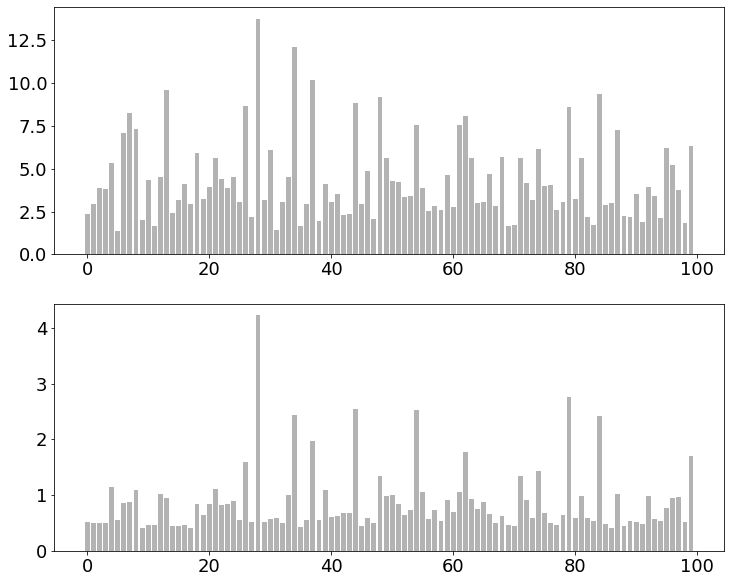

In [52]:
## select random 20 - shuffle
ntot = len(ns)
E_tri = np.zeros(100)
con_tri = np.copy(E_tri)
for jtrials in range(100):
    ni = np.random.choice(ntot,20)
    nsr = ns[ni]
    P = np.zeros(n)
    P[nsr] = 1

    # compute M matrix
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area

    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
    atild = np.linalg.solve(M2,ftild) # compute error
    f1 = yharm @ atild        # iterative reconstruction
    E_tri[jtrials] = np.linalg.norm(f1-f) # iterative error
    con_tri[jtrials] = np.linalg.cond(M2)

fig, axs = plt.subplots(2,1)
axs[0].bar(range(100),np.log(con_tri),facecolor=(0.7,0.7,0.7))
axs[1].bar(range(100),np.log(E_tri+1),facecolor=(0.7,0.7,0.7))

plt.show()

E[3:5] = 0
con[3:5] = 0
Estri = np.sort(E_tri)
contri = np.sort(con_tri)
E[5:10] = Estri[:5]
con[5:10] = contri[:5]
con[10:12] = 0
E[10:12] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log


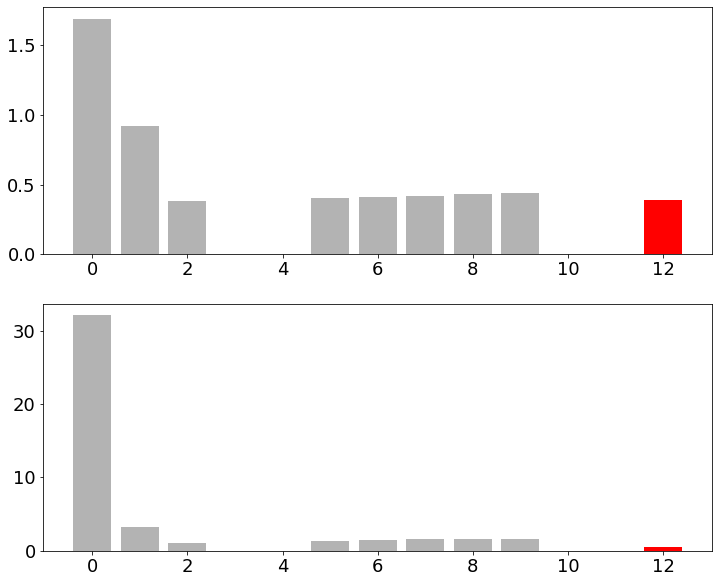

In [55]:
## Method to compare -- Willcox condition number
n2 = 20 # number of sensors
nall = np.arange(n)
ns = np.array([],dtype='int')
kond = np.zeros(n2)
Psum = np.zeros((n,n2))
f1 = np.zeros((n,n2))
EW = np.zeros(n2)
for jsense in range(n2):
    con2 = np.zeros(n-jsense-1)
    for jloop in range(n-jsense-1):
        P = np.zeros(n)
        P[ns] = 1
        P[nall[jloop]] = 1
        
        # compute M matrix
        M2 = np.zeros((10,10))
        for jj in range(10):
            for kk in range(jj+1):
                Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
                M2[jj,kk] = Area
                M2[kk,jj] = Area
        
        con2[jloop] = np.linalg.cond(M2) # compute condition number
    n1 = np.argmin(con2) # location to minimize condition #
    s1 = con2[n1]
    kond[jsense] = s1
    ns = np.append(ns,nall[n1]) # add sensor location
    nall = np.setdiff1d(nall,ns) # new sensor indices
    P = np.zeros(n)
    P[ns] = 1
    Psum[:,jsense] = P
    M2 = np.zeros((10,10))
    for jj in range(10):
        for kk in range(jj+1):
            Area = np.trapz(P*yharm[:,jj]*yharm[:,kk],x)
            M2[jj,kk] = Area
            M2[kk,jj] = Area
            
    ftild = np.zeros(10)
    for jj in range(10): # reconstruction using gappy
        ftild[jj] = np.trapz(P*(f*yharm[:,jj]),x)
    atild = np.linalg.solve(M2,ftild) # compute error
    f1[:,jsense] = yharm @ atild        # iterative reconstruction
    EW[jsense] = np.linalg.norm(f1[:,jsense]-f) # iterative error
    
E[12] = EW[-1]
con[12] = kond[-1]

dum1 = np.zeros(13)
dum2 = np.zeros(13)
dum1[-1] = EW[-1]
dum2[-1] = kond[-1]

fig, axs = plt.subplots(2,1)
axs[0].bar(range(13),np.log(E+1),facecolor=(0.7,0.7,0.7))
axs[1].bar(range(13),np.log(con),facecolor=(0.7,0.7,0.7))
axs[0].bar(range(13),np.log(dum1+1),facecolor='r')
axs[1].bar(range(13),np.log(dum2),facecolor='r')


plt.show()

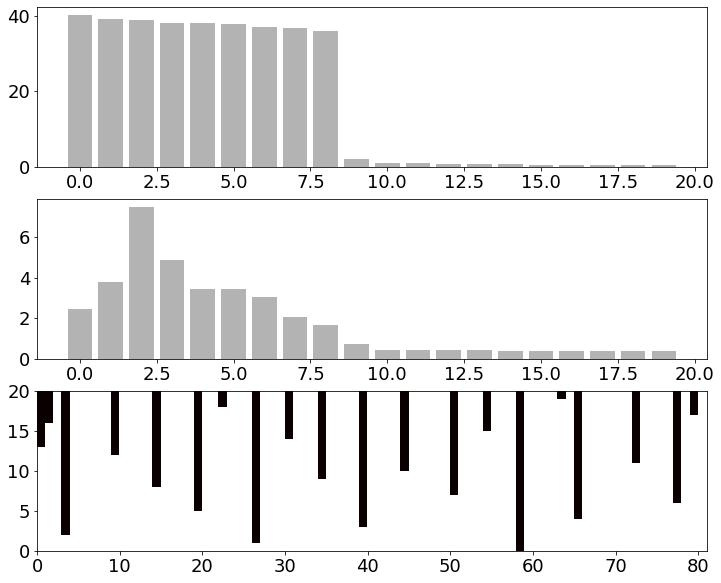

In [57]:
fig,axs = plt.subplots(3,1)
axs[0].bar(range(len(kond)),np.log(kond),facecolor=(0.7,0.7,0.7))
axs[1].bar(range(len(EW)),np.log(EW+1),facecolor=(0.7,0.7,0.7))
axs[2].pcolor(-Psum.T,cmap='hot')
plt.show()

In [59]:
titer = np.arange(1,21)
titer = np.append(titer,25)
titer2 = np.arange(9,21)
titer2 = np.append(titer2,25)
f1 = np.concatenate((f1,f.reshape(n,1)),axis=1)
f2 = np.concatenate((f1[:,9:21],f.reshape(n,1)),axis=1)

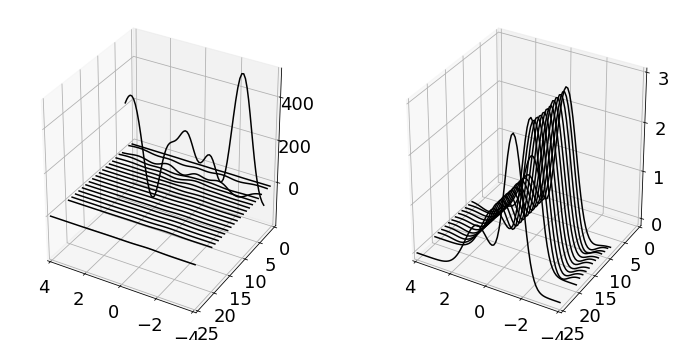

In [60]:
plt.rcParams['figure.figsize'] = [12,6]
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': '3d'})
for ti in range(len(titer)):
    axs[0].plot(x,titer[ti]*np.ones_like(x),f1[:,ti],color='k')
    
for ti in range(len(titer2)):
    axs[1].plot(x,titer2[ti]*np.ones_like(x),f2[:,ti],color='k')
    
for ax in axs:
    ax.view_init(azim=120,elev=30)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,25)
